## Imports & function definitions

In [13]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import squidpy as sq


from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, save_to_pickle, load_from_pickle
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from sklearn.cluster import KMeans

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()


In [2]:
# This is the publication iteration of regions
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')

# Get unique region names
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()

# Get unique regions colors
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']

# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]

for sample in samples:
    adata_slides[sample].obs['predicted_region'] = adata_slides[sample].obs['predicted_region'].replace(replace_dict)

# Create color legend
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
color_dict = dict(zip(regions,region_colors))

In [21]:
meta.columns

Index(['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'n_counts', 'size_factors', 'sample_id', 'joint_leiden_clusters',
       'predicted_region', 'B cells', 'DC', 'FOSL1 tumor epithelium', 'ILC',
       'Macrophages', 'Mast cells', 'Monocytes', 'Neuronal', 'Plasma cells',
       'T cells', 'angiogenic endothelium', 'basal epithelium',
       'cancer epithelium', 'capillary venous endothelium',
       'chaperone response endothelium', 'chaperone response epithelium',
       'chaperone response fibroblasts', 'cycling epithelium', 'fibroblasts',
       'interferon signaling epithelium', 'intermediate CRPC epithelium',
       'luminal epithelium', 'mesenchymal epithelium', 'muscle',
       'stress response fibroblasts', 'stress signaling epithelium'],
      dtype=

In [3]:

# Define functions
def get_spot_interfaces(dat, cluster_of_interest, interaction_cluster, annotation_key = 'predicted_region',added_key='proximity_analysis'):
    # Modified on 31.10. to make the interface subsetting work both ways

    # Create an observation column for spatial segmentation
    dat.obs[added_key] = np.nan
    distance_mat = dat.obsp['spatial_distances'].todense()

    for idx, obs_name in enumerate(dat.obs_names):
        cl = dat.obs[annotation_key][idx]

        if cl in [cluster_of_interest,interaction_cluster]:

            first_nhbor_idxs = np.where(distance_mat[:,idx]==1.0)[0] # Get first-term neighbor indices

            try:
                # If try fails, there are no matching clusters as keys in value_counts
                n_cl_neighbors = dat[first_nhbor_idxs].obs[annotation_key].value_counts()[cl] # find first-term neighbor cluster annotations POSSIBLE ERROR IF CL NOT IN DICT

                # Added this clause to control that only those with 'close' interactions with the interaction cluster are included. 
                all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0]

                # Downgraded the number of required first neighbors to one
                if cl == cluster_of_interest:
                    if (n_cl_neighbors >= 0) & (sum(dat.obs[annotation_key][all_nhbor_indices] == interaction_cluster) >= 3):
                        dat.obs.at[obs_name,added_key] = cl

                elif cl == interaction_cluster:
                    if (n_cl_neighbors >= 0) & (sum(dat.obs[annotation_key][all_nhbor_indices] == cluster_of_interest) >= 3):
                        dat.obs.at[obs_name,added_key] = cl


            except:
                continue
    '''
    # Make a second loop to make sure the final cluster-of-interest annotations
    # are what's used to define proximal spots
    for idx, obs_name in enumerate(dat.obs_names):
        cl = dat.obs[added_key][idx]

        if cl == cluster_of_interest:
            
            all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0] 

            # Get the indices where neighboring spots are not the interest cluster 
            indices = np.where((dat.obs[added_key][all_nhbor_indices] != cl) & (dat.obs[annotation_key][all_nhbor_indices] == interaction_cluster))[0]

            # Update the 'proximity_analysis' column for the specific indices
            dat.obs.loc[dat.obs_names[all_nhbor_indices[indices]], added_key] = interaction_cluster
    '''
    # Modify the colors to maintain the original cluster color
    dat.obs[added_key] = dat.obs[added_key].astype('category')

    return(dat)



def most_common_interactions(dct):
    tuple_lst = []
    for key in dct.keys():
        [tuple_lst.append(tup) for tup in dct[key]]
    res = pd.Series(tuple_lst).value_counts()
    return(res)

def merge_dicts(dict1, dict2):
    merged_dict = {}

    for key, value in dict1.items():
        if key in dict2:
            merged_dict[key] = [value, dict2[key], value - dict2[key]]
        else:
            merged_dict[key] = [value, 0, value]

    for key, value in dict2.items():
        if key not in merged_dict:
            merged_dict[key] = [0, value, 0 - value]

    return merged_dict

def check_gene_marker_status(gene):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_231102.pkl')

    for r in regions:
        fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
        fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
        if fishers_test_df['gene'].str.contains(gene).any(): 
            print(fishers_test_df[fishers_test_df['gene']==gene])
            print('')

def check_top_markers(r,n=20):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_231102.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    return fishers_test_df[:n]

## Subset proximal spots, calculate receptor-ligand analysis and plot

In [ ]:
import matplotlib.patches as patches

# Create an empty list to store legend handles
legend_handles = []

# Iterate over the dictionary items
for name, color in color_dict.items():
    # Create a colored circle patch
    patch = patches.Patch(color=color, label=name)
    # Add the patch to the legend handles list
    legend_handles.append(patch)

In [ ]:
from itertools import combinations
region_combinations = list(combinations(regions,2))

In [ ]:
for tup in region_combinations:
    source = tup[0]
    target = tup[1]
    valid_samples = []

    it=0
    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

    for i in range(5):
        for j in range(8):
            
            # There are at least 10 of both regions
            if it < len(samples) :
                
                slide = adata_slides[samples[it]]
                # Using three rings you get 6 immediate neigbors, 12 second neigbors and 18 third neighbors
                sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=3)
        

                # First check to see if there are sufficient amount of spots to look for proximal ones
                if (slide.obs['predicted_region'].str.contains(source).sum() >= 10) & (slide.obs['predicted_region'].str.contains(target).sum() >= 10):
                    
                    slide = get_spot_interfaces(slide, source, target)
    

                    if not (slide.obs['proximity_analysis'].isna().all()):
                        # Second check to see if there are sufficient amount of spots to plot and do ligrec (10)
                        if (slide.obs['proximity_analysis'].str.contains(source).sum() >= 10) & (slide.obs['proximity_analysis'].str.contains(target).sum() >= 10):

                            ## Plotting ##
                            slide.uns['proximity_analysis_colors'] = [color_dict[cat] for cat in slide.obs['proximity_analysis'].cat.categories]

                            # create spatial plot
                            sc.pl.spatial(slide,color='proximity_analysis',title=samples[it],
                                                    crop_coord=sample_crop_coord[samples[it]],
                                                    size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                                                    ax=axs[i,j],show=False
                                                    )
                            axs[i,j].set_xlabel(None)
                            axs[i,j].set_ylabel(None)

                            # Append this sample to the list
                            valid_samples.append(samples[it])

                        else:
                            axs[i,j].set_visible(False)
                    else:
                        axs[i,j].set_visible(False)
                else:
                    axs[i,j].set_visible(False)
            else:
                axs[i,j].set_visible(False)
            
            it+=1


    plt.tight_layout()

    # create custom axes for the annotation legend 
    cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
    cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

    cax1.axis('off')
    cax1.legend(handles=legend_handles[:4],loc='center',markerscale=4,fontsize='xx-large')
    cax2.axis('off')
    cax2.legend(handles=legend_handles[4:],loc='center',markerscale=4,fontsize='xx-large')

    plt.savefig('./plots/receptor_ligand_interaction_analysis/v2_'+source.replace(' ','_')+'_'+target.replace(' ','_')+'_proximity_regions.pdf')
    plt.clf()


    #### Second part, using valid_samples to do ligrec #####
    ligrec_dict = {}
    for sample in valid_samples:

        if len(adata_slides[sample].obs['proximity_analysis'].unique()) >=3:
            slide = adata_slides[sample].copy()
            slide.obs['proximity_analysis'] = slide.obs['proximity_analysis'].cat.add_categories(['NA'])
            slide.obs['proximity_analysis'] = slide.obs['proximity_analysis'].fillna('NA')

            ligrec_res = sq.gr.ligrec(
                slide,
                cluster_key='proximity_analysis',
                clusters = [source,target],
                complex_policy='all',
                show_progress_bar = False,
                seed=25234169,
                copy=True
            )

            ligrec_dict[sample] = ligrec_res

    save_to_pickle(ligrec_dict,'./data/region_ligrec_analysis/v2_'+source.replace(' ','_')+'_'+target.replace(' ','_')+'_slides_with_ligrec.pkl')

    print('')
    print('')
    print(source+ ' <--> ' + target + ' done!')



In [ ]:
# Saving figures in high resolution
sc.set_figure_params(figsize=(3,3),dpi_save=1200)

#for sample in ['PC_06_04581_OIK_POST_0']:

sample = 'PC_06_04581_OIK_POST_0'
slide = adata_slides[sample].copy()
it= 0

for i in range(2):
    for j in range(4):
        
        region_of_interest = regions[it]
            
        slide.obs['region_of_interest'] = np.nan

        slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

        slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

        slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

    
        n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]

        sc.pl.spatial(slide,color='region_of_interest',
                crop_coord=sample_crop_coord[sample],
                size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                save=sample+'_'+region_of_interest+'.pdf_sum',show=False
            )
        it += 1

In [ ]:
# Saving figures in high resolution
sc.set_figure_params(figsize=(3,3),dpi_save=1200)

#for sample in ['PC_06_04581_OIK_POST_0']:

sample = 'PC_06_04581_OIK_POST_0'
regions_to_plot = [t for t in list(combinations(regions,2)) if 'Tumor' in t]


for tup in regions_to_plot:
    source = tup[0]
    target = tup[1]
    
    slide = adata_slides[sample].copy()
    sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=3)
        
    slide = get_spot_interfaces(slide, source, target)
    
    slide.uns['proximity_analysis_colors'] = [color_dict[cat] for cat in slide.obs['proximity_analysis'].cat.categories]

    sc.pl.spatial(slide,color='proximity_analysis',crop_coord=sample_crop_coord[sample],title='',
                        size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',show=False,
                        save=sample+'_'+source.replace(' ','_')+'_'+target.replace(' ','_')+'.pdf_sum'
                        )

## Loading the data from pickle for analysis

In [225]:
def get_ligrec_results(results_dict,source_region, target_region, pval = 0.01,reverse=False):
    # Function only reports those means that have a below-threshold p-value

    if reverse:
        source = source_region
        source_region = target_region
        target_region = source

    for i,s in enumerate(list(results_dict.keys())):
        means = results_dict[s]['means'][source_region][target_region]
        pvals = results_dict[s]['pvalues'][source_region][target_region]
        means = pd.DataFrame(means[pvals[pvals<pval].index])
        means = means.rename(columns={target_region:s})
        meta = results_dict[s]['metadata'].loc[means.index]

        if i==0:
            means_all = means
            metas_all = meta
        else:
            means_all = pd.merge(means_all,means,how='outer',left_index=True,right_index=True)
            metas_all = pd.concat([metas_all,meta],axis=0)

    # Drop duplicate indices
    metas_all.drop_duplicates(inplace=True)
    # Option of returning the results dict if needed
    return means_all, metas_all

def filter_ligrec_results(ligrec_res_dict,valid_samples):
    for k in list(ligrec_res_dict.keys()):
        df_sum = ligrec_res_dict[k].copy()
        df_sum = df_sum[[c for c in df_sum.columns if c in valid_samples]]
        ligrec_res_dict[k] = df_sum
    
    return(ligrec_res_dict)


def format_dotplot_df(plot_df, interfaces, n_interactions_per_interface=10, filter_by_n_regions=0,filter_duplicates = True):
    
    plot_df = plot_df[plot_df['interaction'].isin(interfaces)]
    # Filter out interactions that are present in all
    if filter_by_n_regions:
        val_counts = plot_df['molecules'].value_counts()
        not_in_all_regions_idxs = val_counts[val_counts < len(interfaces)-filter_by_n_regions].index
        plot_df = plot_df.loc[not_in_all_regions_idxs]

    final_idxs_list = []

    for k in interfaces:

        df_sum = plot_df[plot_df['interaction'] == k].sort_values(['pct_in','mean'],ascending=False)

        ####### R/L DUPLICATE FILTERING BEGINS HERE ######
        if filter_duplicates:
            l_list = []
            r_list = []
            valid_idxs = []
            for idx,tup in enumerate(df_sum['molecules']):
                if ((tup[0] not in l_list) & (tup[1] not in r_list)):
                    l_list.append(tup[0])
                    r_list.append(tup[1])
                    valid_idxs.append(idx)

            df_sum = df_sum.iloc[valid_idxs]
        ####### STOPS HERE ######   

        final_idxs_list += df_sum[:n_interactions_per_interface].sort_index().index.tolist()

    plot_df = plot_df.loc[pd.Series(final_idxs_list).unique().tolist()]
    plot_df.loc[plot_df['pct_in'] == 0,'pct_in'] = np.nan

    return(plot_df)

def cluster_rows(df,num_clusters=7):
    # Perform K-means clustering with the desired number of clusters

    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df)

    # Get the cluster labels assigned to each row
    cluster_labels = kmeans.labels_

    # Add the cluster labels as a new column in the original dataframe
    df['cluster_label'] = cluster_labels

    # Sort the dataframe based on the cluster labels
    df_sorted = df.sort_values(by=['cluster_label'])

    idx = []
    for l in df_sorted['cluster_label'].unique():
        idx += df_sorted[df_sorted['cluster_label']==l].sort_index().index.tolist()
    df_sorted.drop(columns='cluster_labels',inplace=True)

    return(df_sorted)


In [226]:
roi = 'Immune' # Original source region. Flip the reverse switch on if you intend this to be the target
roi_is_target = True # Set to true if wish to look at the interaction where roi has the receptors

if roi_is_target:
    which_molecule = 'ligand'
    anti_molecule = 'receptor'
else:
    which_molecule = 'receptor'
    anti_molecule = 'ligand'

orig_combs = list(combinations(regions,2))
prox_regions = [t for t in orig_combs if roi in t]


## Download ligrec results and their metadata
ligrec_results = {}
meta_all = pd.DataFrame()

for reg_couple in prox_regions:
    r1 = reg_couple[0]
    r2 = reg_couple[1]
    key = r1.replace(' ','_') + '_' + r2.replace(' ','_')

    # Load the data
    results_dict = load_from_pickle('./data/region_ligrec_analysis/v2_'+r1.replace(' ','_')+'_'+r2.replace(' ','_')+'_slides_with_ligrec.pkl')

    # Flip the direction if the region of interest (ROI) is second. This matches the direction of all comparisons, but can still be reversed if roi_is_target = True
    if roi == r2:
        r_temp = r2
        r2 = r1
        r1 = r_temp

    df_sum,meta = get_ligrec_results(results_dict, r1, r2, pval=0.05, reverse=roi_is_target)
    ligrec_results[key] = df_sum
    meta_all = pd.concat([meta_all,meta],axis=0)

keys = list(ligrec_results.keys())
meta_all.drop_duplicates(inplace=True)

# Filtering samples
sample_list = get_sample_ids_reorder(['BPH','untreated'])
#sample_list = get_sample_ids_reorder(['bicalutamide','goserelin','CRPC'])

# Filter out samples that are not of interest
ligrec_results = filter_ligrec_results(ligrec_results,sample_list)


## Summarize the ligand-receptor pair results
summarized_ligrec_results = {}
for k in keys:
    df_sum = ligrec_results[k].copy()
    n_samples = df_sum.shape[1]
    pct_active = (~df_sum.isna()).sum(axis=1)#/n_samples ######## Here you can affect whether you look at percentages or numbers of samples
    mean_activity = df_sum.mean(axis=1)
    summarized_df_sum = pd.DataFrame({'mean':mean_activity,'pct_in':pct_active,'interaction':k})
    summarized_ligrec_results[k] = summarized_df_sum

summarized_ligrec_df = pd.concat(summarized_ligrec_results.values(),axis=0)


# Filtering interactions according to metadata annotation
score_filter = 10
meta = meta_all.copy()
accepted_sources = ['CellPhoneDB']
meta = meta[(meta['consensus_score_intercell_target']>score_filter) & (meta['consensus_score_intercell_source']>score_filter)]
summarized_ligrec_df = summarized_ligrec_df.loc[meta.index.drop_duplicates()]

summarized_ligrec_df['molecules'] = list(summarized_ligrec_df.index)
summarized_ligrec_df['ligand'] = summarized_ligrec_df.index.get_level_values(0)
summarized_ligrec_df['receptor'] = summarized_ligrec_df.index.get_level_values(1)


print('Sample numbers:')
interface_n = {}
for k in keys:
    n = ligrec_results[k].shape[1]
    print(k + ': ' + str(n))
    
    interface_n[k] = n

############################################################################


Sample numbers:
Tumor_Immune: 7
Luminal_epithelium_Immune: 8
Basal_epithelium_Immune: 5
Intermediate_epithelium_Immune: 9
Immune_Endothelium: 2
Immune_Fibroblast: 12
Immune_Muscle: 10


In [29]:

signif_pval_interactions = pd.DataFrame()

for interface in keys:

    df = summarized_ligrec_df.pivot_table(values='pct_in',index= 'molecules',columns='interaction').fillna(0)
    other_keys = [c for c in df.columns if c != interface]
    df['diff'] = df[interface] - df[other_keys].mean(axis=1)
    df['control_mean'] = df[other_keys].mean(axis=1)
    df = df.sort_values('diff',ascending=False)[keys+['diff','control_mean']]

    n_sample = interface_n[interface]
    n_control = pd.Series([interface_n[k] for k in other_keys]).sum()

    df = df.sort_index()

    # Perform Fisher's exact test on all 
    for iact in df.index:
        a = df[interface].loc[[iact]]
        c = df[other_keys].sum(axis=1).loc[[iact]]
        b = n_sample-a
        d = n_control-c
        arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
        stat,pval = fisher_exact(arr,alternative='greater')
        df.loc[[iact],'pval'] = pval

    df['adj_pval'] = multipletests(df['pval'],method='fdr_bh')[1]

    #df_signif = pd.DataFrame({'interaction':interact_list,'active_in':n_active_in_list,'adj_pval':adj_pval_list,'interface':np.repeat(interface,len(interact_list))})
    df_signif = pd.DataFrame({'interaction':df.index.tolist(),
                              'active_in':df[interface].astype(int).tolist(),
                              'adj_pval':df['adj_pval'].tolist(),
                              'interface':np.repeat(interface,len(df))})
    signif_pval_interactions = pd.concat([signif_pval_interactions,df_signif],axis=0)

signif_pval_interactions = signif_pval_interactions.sort_values('adj_pval').reset_index(drop=True)
signif_pval_interactions['log10_adj_pval'] = -np.log10(signif_pval_interactions['adj_pval'])
signif_pval_interactions

,interaction,active_in,adj_pval,interface,log10_adj_pval
0,"(SAA1, CD36)",11,0.000718,Tumor_Intermediate_epithelium,3.143904
1,"(CXCL2, ACKR1)",10,0.000718,Tumor_Intermediate_epithelium,3.143904
2,"(CXCL1, ACKR1)",9,0.000718,Tumor_Intermediate_epithelium,3.143904
3,"(ANGPT1, ITGB5)",11,0.000719,Tumor_Muscle,3.143233
4,"(VEGFA, ITGB1)",11,0.001125,Tumor_Luminal_epithelium,2.948854
...,...,...,...,...,...
13708,"(CXCL13, CCR5)",0,1.000000,Tumor_Intermediate_epithelium,-0.000000
13709,"(CXCL13, CCR6)",0,1.000000,Tumor_Intermediate_epithelium,-0.000000
13710,"(CXCL13, CCR7)",0,1.000000,Tumor_Intermediate_epithelium,-0.000000
13711,"(CXCL12, XCR1)",1,1.000000,Tumor_Intermediate_epithelium,-0.000000


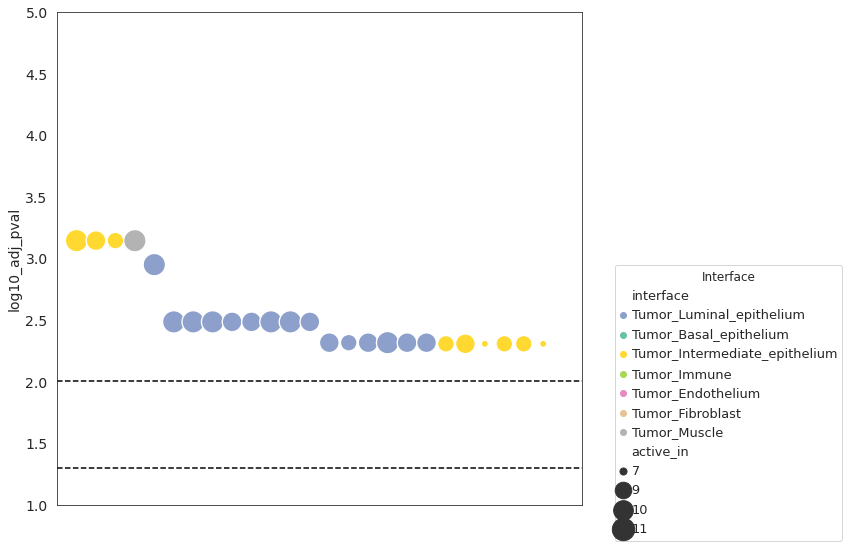

In [30]:
n_interaction = 25
plot_df = signif_pval_interactions[:n_interaction]
plot_df['interface'] = plot_df['interface'].astype('category').cat.set_categories(keys)
# Set the style of the plot
sns.set_style('white')
sns.set_palette([color_dict[r] for r in regions if r != roi])

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Create the dotplot
sns.scatterplot(x=plot_df.index, y='log10_adj_pval', size='active_in',
                hue='interface', data=plot_df, ax=ax, sizes=(50,500))

# Set the y-axis limits and add dashed lines
ax.set_ylim(1, 5) # May need to adjust

ax.set_xlim(-1,n_interaction+1)
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
ax.axhline(y=2, color='black', linestyle='--')

# Set the x-axis label and legend
ax.set_xlabel('Index')
ax.legend(title='Interface',bbox_to_anchor=(1.05, 0.5))
ax.set_xticklabels([])
ax.set_xlabel('')

plt.tight_layout()

if roi_is_target:
    plt.savefig('plots/interface_ligrec_dotplots/'+roi+'_as_target_fishers_test_adj_pval.pdf')
    plot_df.to_csv('./plots/interface_ligrec_dotplots/'+roi+'_as_target_fishers_test_adj_pval.csv')
else:
    plt.savefig('plots/interface_ligrec_dotplots/'+roi+'_as_source_fishers_test__adj_pval.pdf')
    plot_df.to_csv('./plots/interface_ligrec_dotplots/'+roi+'_as_source_fishers_test_adj_pval.csv')
# Show the plot
plt.show()


In [245]:
check_gene_marker_status('SPRR1')

In [239]:
tumor_markers = check_top_markers('Tumor',500)
luminal_markers = check_top_markers('Luminal epithelium',500)

#luminal_markers[~(luminal_markers['gene'].isin(list(tumor_markers['gene'])))]
tumor_markers[~(tumor_markers['gene'].isin(list(luminal_markers['gene'])))]

,gene,deg in,adj_pval,interface
0,SNHG8,18,3.628950e-11,Tumor
1,SNHG19,17,3.628950e-11,Tumor
2,HPN,19,3.628950e-11,Tumor
3,AL445524.1,14,4.481036e-11,Tumor
4,PCAT14,17,6.082842e-11,Tumor
...,...,...,...,...
495,CMC1,4,4.818736e-03,Tumor
496,MCM2,4,4.818736e-03,Tumor
497,HDHD5-AS1,4,4.818736e-03,Tumor
498,ZNF793-AS1,4,4.818736e-03,Tumor


In [ ]:
""" 
iact = ('CXCL2','ADRA2A')
interface = 'Intermediate_epithelium_Immune'

df = summarized_ligrec_df.pivot_table(values='pct_in',index= 'molecules',columns='interaction').fillna(0)
other_keys = [c for c in df.columns if c != interface]
n_sample = interface_n[interface]
n_control = pd.Series([interface_n[k] for k in other_keys]).sum()

df = df.sort_index()

# Perform Fisher's exact test on all 
a = df[interface].loc[[iact]]
c = df[other_keys].sum(axis=1).loc[[iact]]
b = n_sample-a
d = n_control-c

arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
stat,pval = fisher_exact(arr,alternative='greater')
print(arr)
print(str(iact) + ' fishers test pval: {:.1e}'.format(pval))

df = summarized_ligrec_df.pivot_table(values='pct_in',index= 'molecules',columns='interaction').fillna(0)
df['sum'] = df.sum(axis=1)
df = df.sort_values('sum',ascending=False)[keys+['sum']].astype(int)
df[:30]

  """

Sample numbers:
Tumor_Luminal_epithelium: 16
Tumor_Basal_epithelium: 10
Tumor_Intermediate_epithelium: 12
Tumor_Immune: 7
Tumor_Endothelium: 1
Tumor_Fibroblast: 12
Tumor_Muscle: 12


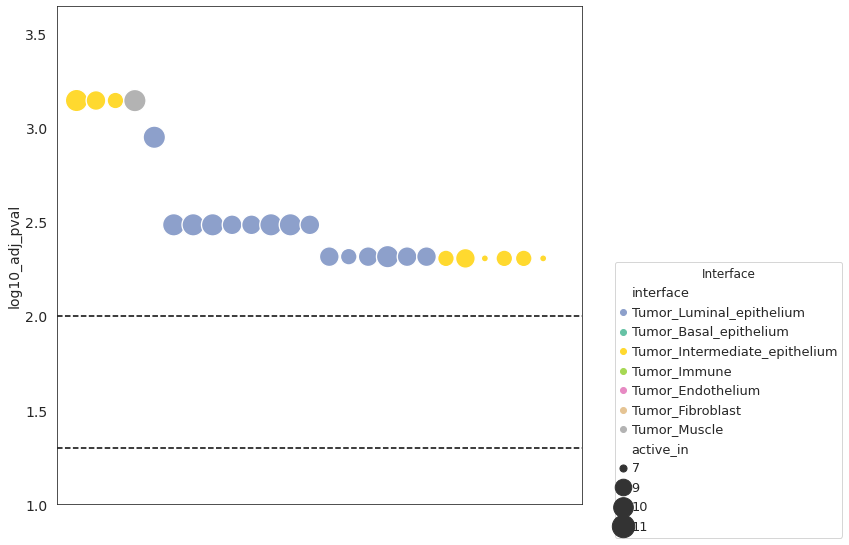

Sample numbers:
Tumor_Luminal_epithelium: 16
Tumor_Basal_epithelium: 10
Tumor_Intermediate_epithelium: 12
Tumor_Immune: 7
Tumor_Endothelium: 1
Tumor_Fibroblast: 12
Tumor_Muscle: 12


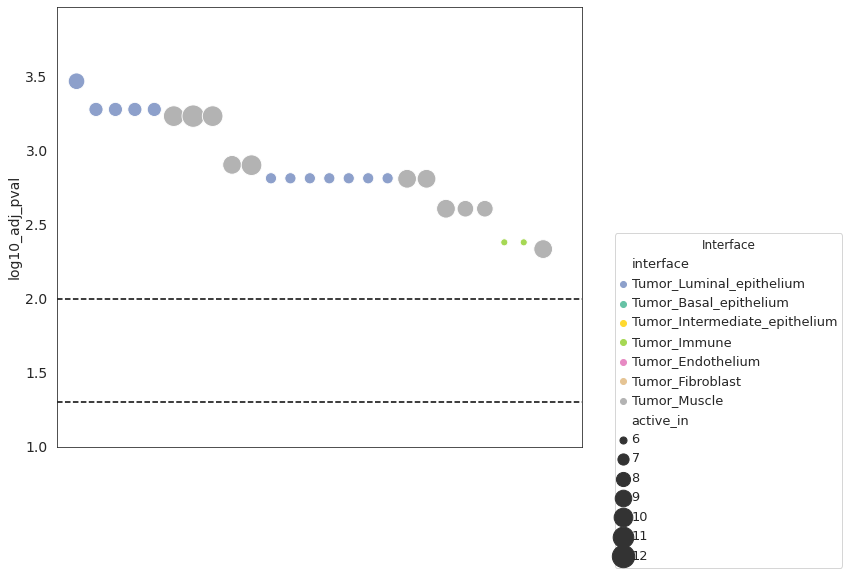

Sample numbers:
Tumor_Luminal_epithelium: 16
Luminal_epithelium_Basal_epithelium: 10
Luminal_epithelium_Intermediate_epithelium: 14
Luminal_epithelium_Immune: 8
Luminal_epithelium_Endothelium: 1
Luminal_epithelium_Fibroblast: 14
Luminal_epithelium_Muscle: 15


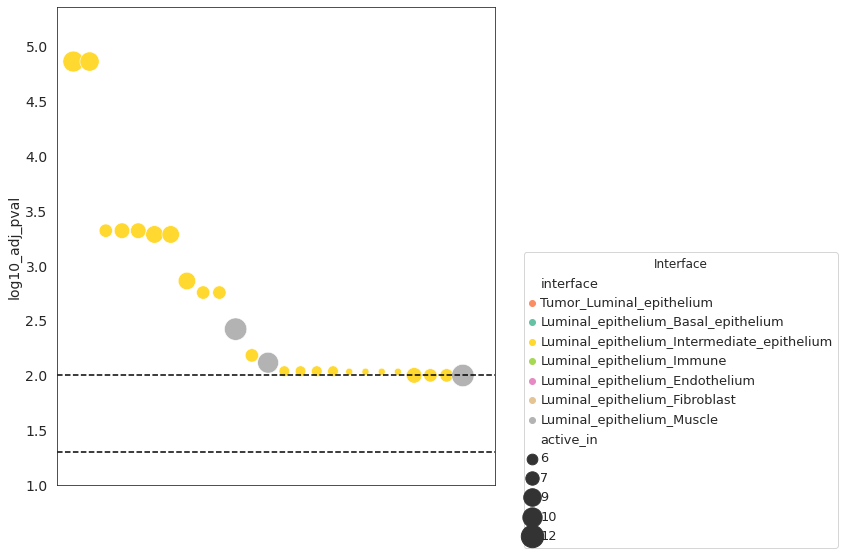

Sample numbers:
Tumor_Luminal_epithelium: 16
Luminal_epithelium_Basal_epithelium: 10
Luminal_epithelium_Intermediate_epithelium: 14
Luminal_epithelium_Immune: 8
Luminal_epithelium_Endothelium: 1
Luminal_epithelium_Fibroblast: 14
Luminal_epithelium_Muscle: 15


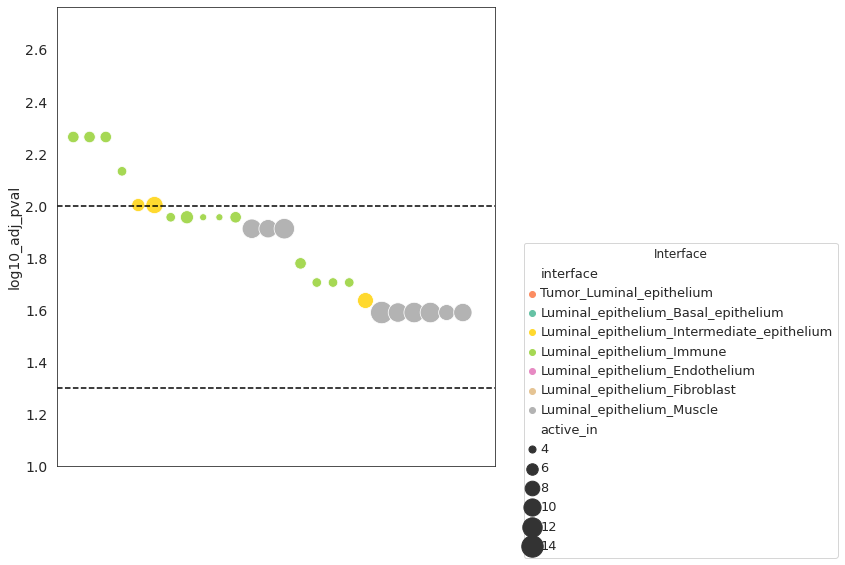

Sample numbers:
Tumor_Basal_epithelium: 10
Luminal_epithelium_Basal_epithelium: 10
Basal_epithelium_Intermediate_epithelium: 9
Basal_epithelium_Immune: 5
Basal_epithelium_Endothelium: 0
Basal_epithelium_Fibroblast: 10
Basal_epithelium_Muscle: 12


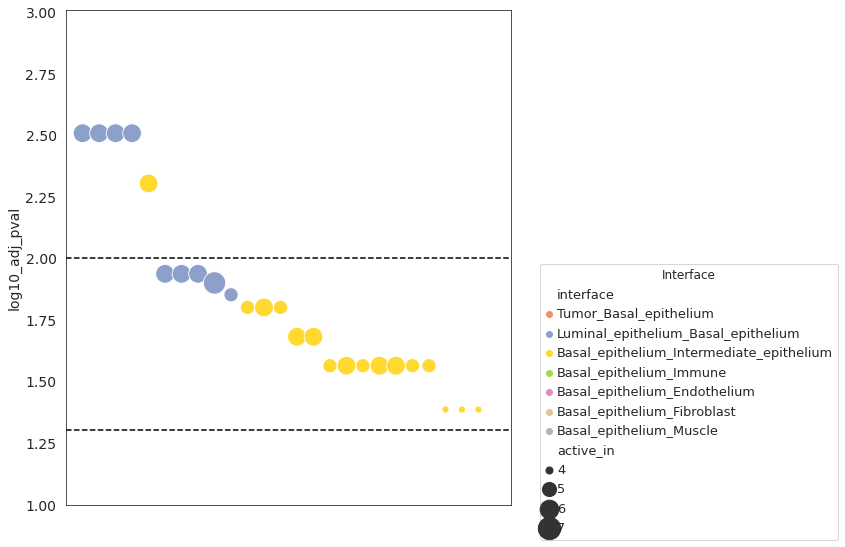

Sample numbers:
Tumor_Basal_epithelium: 10
Luminal_epithelium_Basal_epithelium: 10
Basal_epithelium_Intermediate_epithelium: 9
Basal_epithelium_Immune: 5
Basal_epithelium_Endothelium: 0
Basal_epithelium_Fibroblast: 10
Basal_epithelium_Muscle: 12


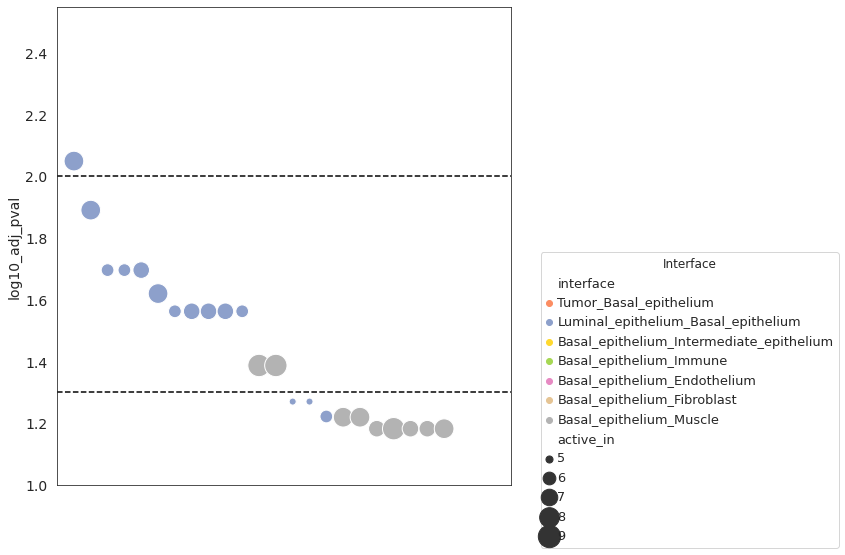

Sample numbers:
Tumor_Intermediate_epithelium: 12
Luminal_epithelium_Intermediate_epithelium: 14
Basal_epithelium_Intermediate_epithelium: 9
Intermediate_epithelium_Immune: 9
Intermediate_epithelium_Endothelium: 2
Intermediate_epithelium_Fibroblast: 14
Intermediate_epithelium_Muscle: 13


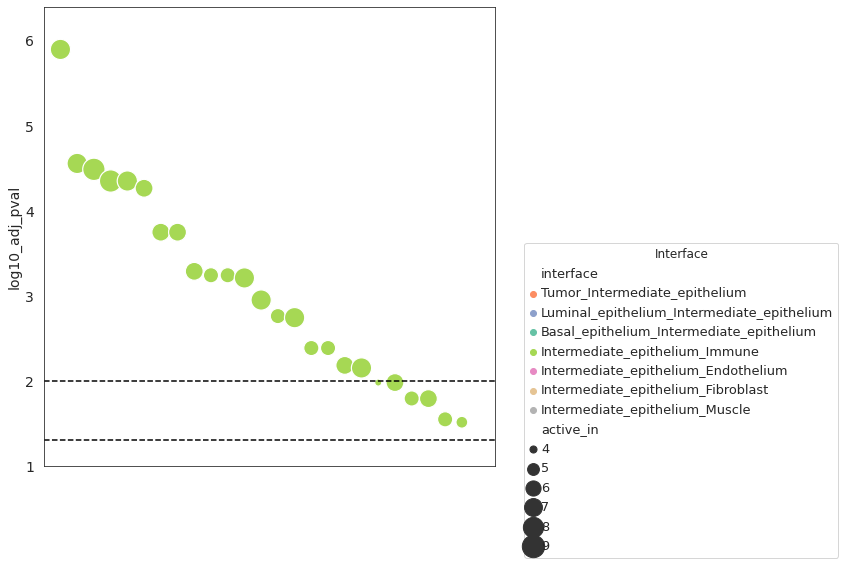

Sample numbers:
Tumor_Intermediate_epithelium: 12
Luminal_epithelium_Intermediate_epithelium: 14
Basal_epithelium_Intermediate_epithelium: 9
Intermediate_epithelium_Immune: 9
Intermediate_epithelium_Endothelium: 2
Intermediate_epithelium_Fibroblast: 14
Intermediate_epithelium_Muscle: 13


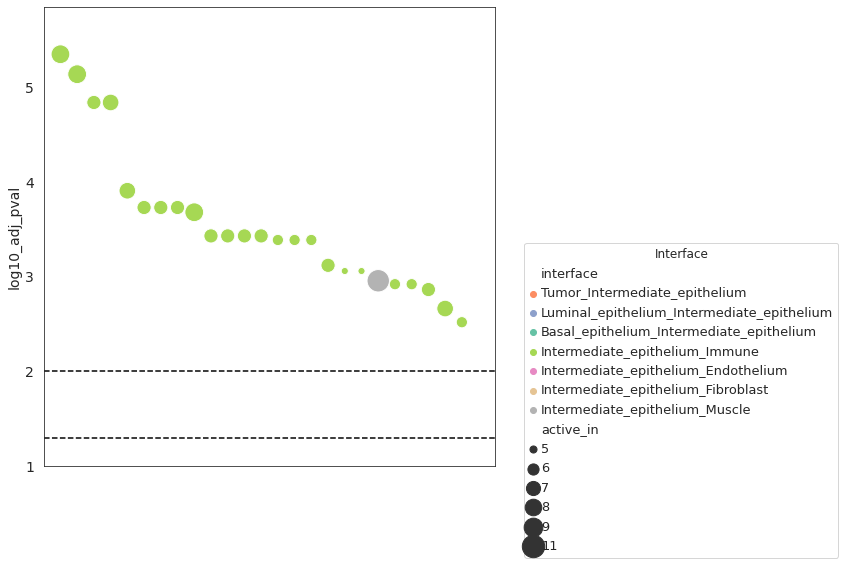

Sample numbers:
Tumor_Immune: 7
Luminal_epithelium_Immune: 8
Basal_epithelium_Immune: 5
Intermediate_epithelium_Immune: 9
Immune_Endothelium: 2
Immune_Fibroblast: 12
Immune_Muscle: 10


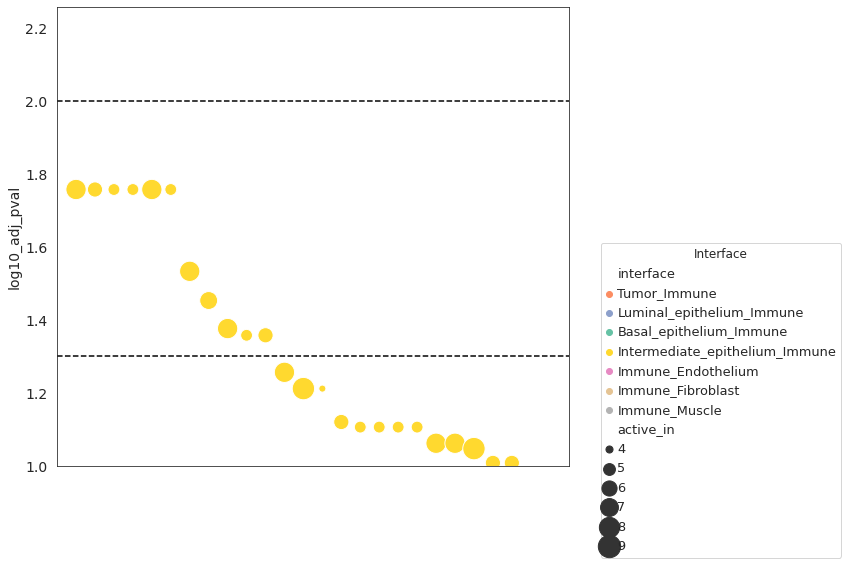

Sample numbers:
Tumor_Immune: 7
Luminal_epithelium_Immune: 8
Basal_epithelium_Immune: 5
Intermediate_epithelium_Immune: 9
Immune_Endothelium: 2
Immune_Fibroblast: 12
Immune_Muscle: 10


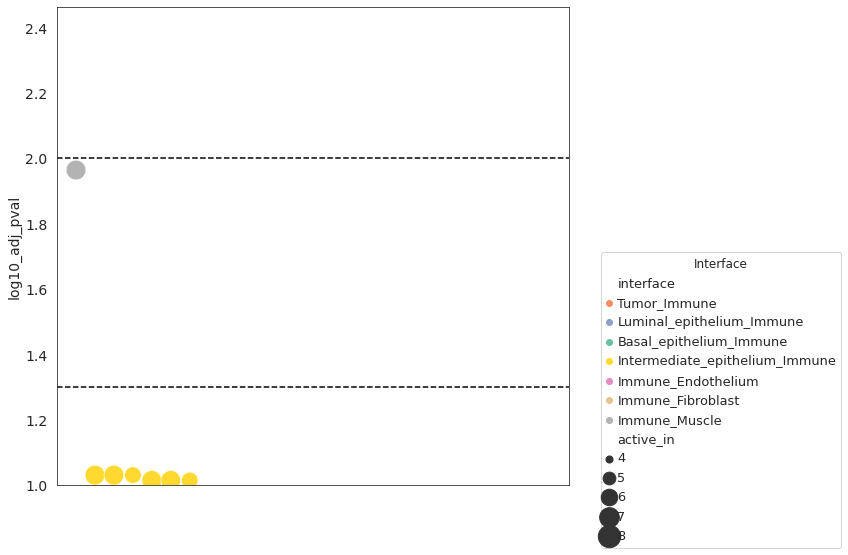

Sample numbers:
Tumor_Endothelium: 1
Luminal_epithelium_Endothelium: 1
Basal_epithelium_Endothelium: 0
Intermediate_epithelium_Endothelium: 2
Immune_Endothelium: 2
Endothelium_Fibroblast: 4
Endothelium_Muscle: 4


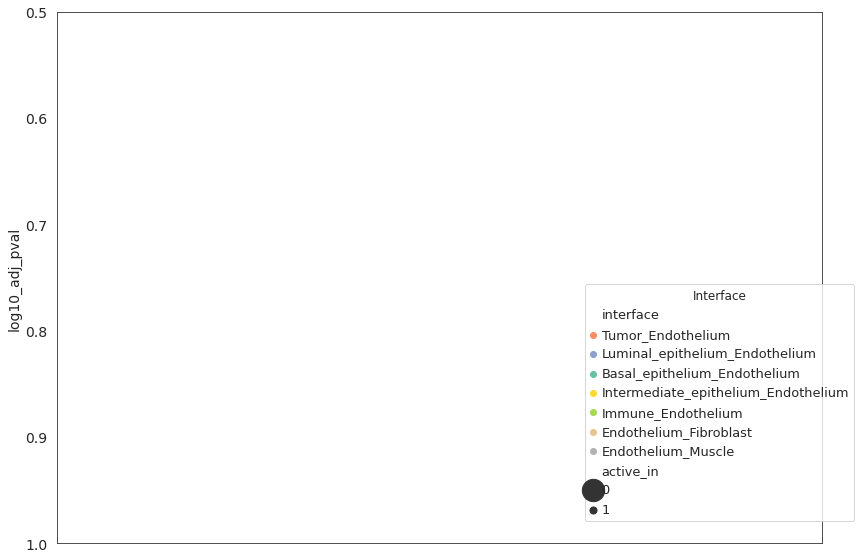

Sample numbers:
Tumor_Endothelium: 1
Luminal_epithelium_Endothelium: 1
Basal_epithelium_Endothelium: 0
Intermediate_epithelium_Endothelium: 2
Immune_Endothelium: 2
Endothelium_Fibroblast: 4
Endothelium_Muscle: 4


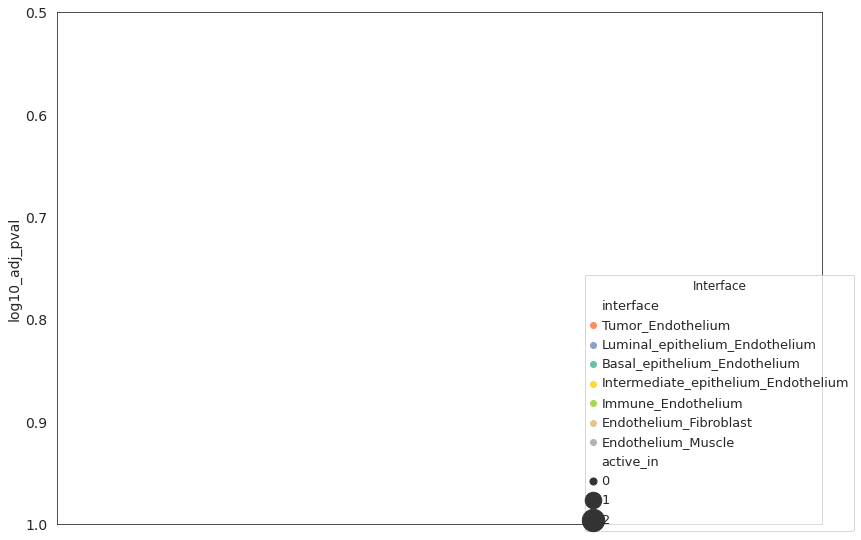

Sample numbers:
Tumor_Fibroblast: 12
Luminal_epithelium_Fibroblast: 14
Basal_epithelium_Fibroblast: 10
Intermediate_epithelium_Fibroblast: 14
Immune_Fibroblast: 12
Endothelium_Fibroblast: 4
Fibroblast_Muscle: 16


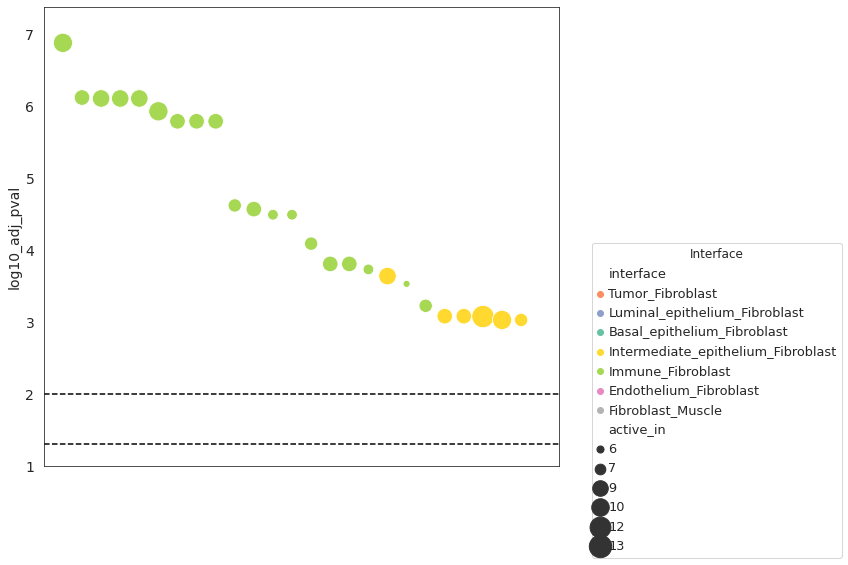

Sample numbers:
Tumor_Fibroblast: 12
Luminal_epithelium_Fibroblast: 14
Basal_epithelium_Fibroblast: 10
Intermediate_epithelium_Fibroblast: 14
Immune_Fibroblast: 12
Endothelium_Fibroblast: 4
Fibroblast_Muscle: 16


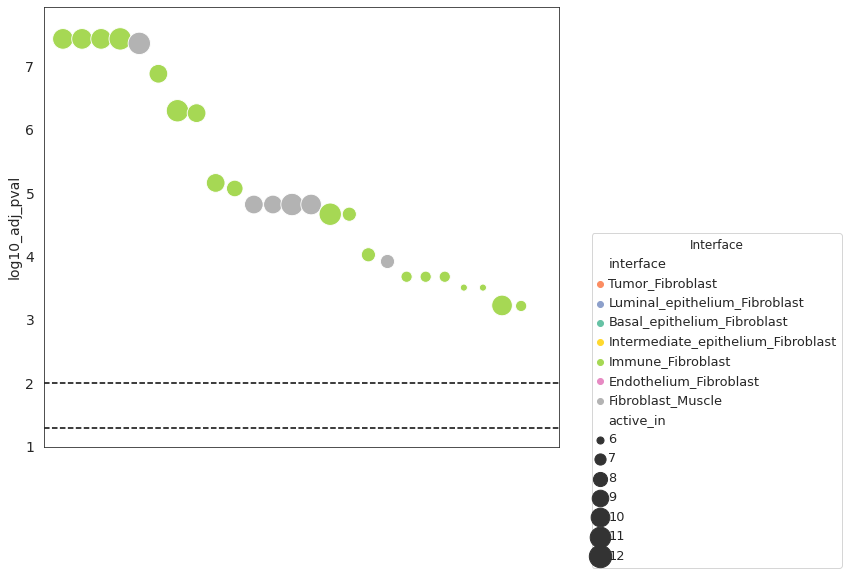

Sample numbers:
Tumor_Muscle: 12
Luminal_epithelium_Muscle: 15
Basal_epithelium_Muscle: 12
Intermediate_epithelium_Muscle: 13
Immune_Muscle: 10
Endothelium_Muscle: 4
Fibroblast_Muscle: 16


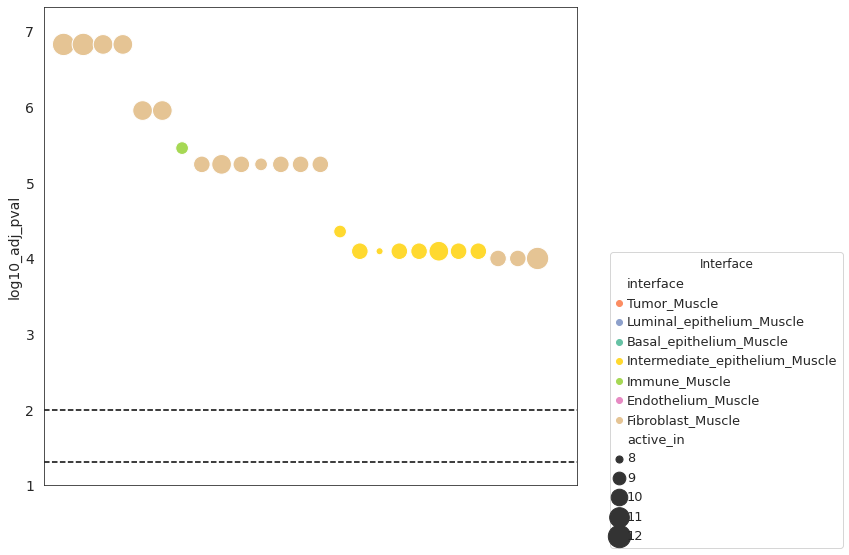

Sample numbers:
Tumor_Muscle: 12
Luminal_epithelium_Muscle: 15
Basal_epithelium_Muscle: 12
Intermediate_epithelium_Muscle: 13
Immune_Muscle: 10
Endothelium_Muscle: 4
Fibroblast_Muscle: 16


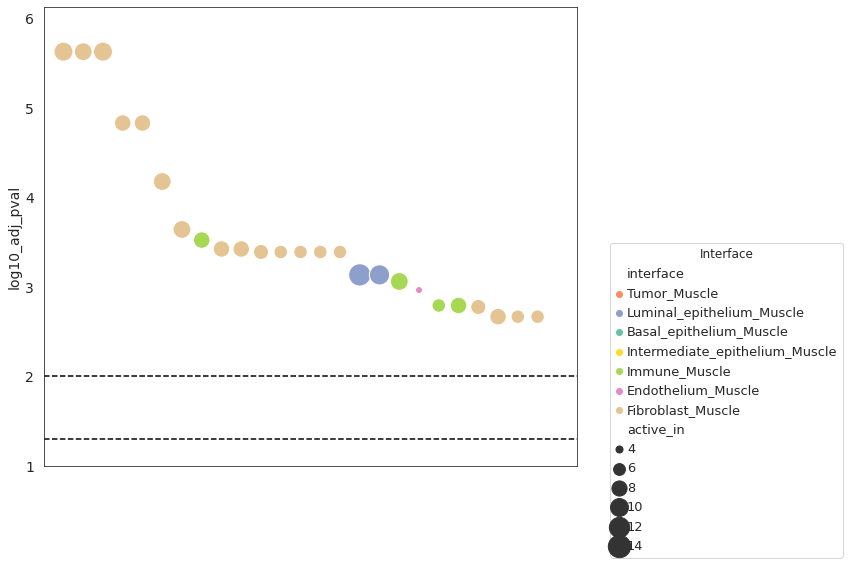

In [33]:
for roi in regions:
    for roi_is_target in [True, False]:
    #roi = 'Tumor' # Original source region. Flip the reverse switch on if you intend this to be the target
    #roi_is_target = True # Set to true if wish to look at the interaction where roi has the receptors

        if roi_is_target:
            which_molecule = 'ligand'
            anti_molecule = 'receptor'
        else:
            which_molecule = 'receptor'
            anti_molecule = 'ligand'

        orig_combs = list(combinations(regions,2))
        prox_regions = [t for t in orig_combs if roi in t]


        ## Download ligrec results and their metadata
        ligrec_results = {}
        meta_all = pd.DataFrame()

        for reg_couple in prox_regions:
            r1 = reg_couple[0]
            r2 = reg_couple[1]
            key = r1.replace(' ','_') + '_' + r2.replace(' ','_')

            # Load the data
            results_dict = load_from_pickle('./data/region_ligrec_analysis/v2_'+r1.replace(' ','_')+'_'+r2.replace(' ','_')+'_slides_with_ligrec.pkl')

            # Flip the direction if the region of interest (ROI) is second. This matches the direction of all comparisons, but can still be reversed if roi_is_target = True
            if roi == r2:
                r_temp = r2
                r2 = r1
                r1 = r_temp

            df_sum,meta = get_ligrec_results(results_dict, r1, r2, pval=0.05, reverse=roi_is_target)
            ligrec_results[key] = df_sum
            meta_all = pd.concat([meta_all,meta],axis=0)

        keys = list(ligrec_results.keys())
        meta_all.drop_duplicates(inplace=True)

        # Filtering samples
        sample_list = get_sample_ids_reorder(['BPH','untreated'])
        #sample_list = get_sample_ids_reorder(['bicalutamide','goserelin','CRPC'])

        # Filter out samples that are not of interest
        ligrec_results = filter_ligrec_results(ligrec_results,sample_list)


        ## Summarize the ligand-receptor pair results
        summarized_ligrec_results = {}
        for k in keys:
            df_sum = ligrec_results[k].copy()
            n_samples = df_sum.shape[1]
            pct_active = (~df_sum.isna()).sum(axis=1)#/n_samples ######## Here you can affect whether you look at percentages or numbers of samples
            mean_activity = df_sum.mean(axis=1)
            summarized_df_sum = pd.DataFrame({'mean':mean_activity,'pct_in':pct_active,'interaction':k})
            summarized_ligrec_results[k] = summarized_df_sum

        summarized_ligrec_df = pd.concat(summarized_ligrec_results.values(),axis=0)


        # Filtering interactions according to metadata annotation
        score_filter = 10
        meta = meta_all.copy()
        accepted_sources = ['CellPhoneDB']
        meta = meta[(meta['consensus_score_intercell_target']>score_filter) & (meta['consensus_score_intercell_source']>score_filter)]
        summarized_ligrec_df = summarized_ligrec_df.loc[meta.index.drop_duplicates()]

        summarized_ligrec_df['molecules'] = list(summarized_ligrec_df.index)
        summarized_ligrec_df['ligand'] = summarized_ligrec_df.index.get_level_values(0)
        summarized_ligrec_df['receptor'] = summarized_ligrec_df.index.get_level_values(1)


        print('Sample numbers:')
        interface_n = {}
        for k in keys:
            n = ligrec_results[k].shape[1]
            print(k + ': ' + str(n))
            
            interface_n[k] = n

        ############################################################################

        signif_pval_interactions = pd.DataFrame()

        for interface in keys:

            df = summarized_ligrec_df.pivot_table(values='pct_in',index= 'molecules',columns='interaction').fillna(0)
            other_keys = [c for c in df.columns if c != interface]
            df['diff'] = df[interface] - df[other_keys].mean(axis=1)
            df['control_mean'] = df[other_keys].mean(axis=1)
            df = df.sort_values('diff',ascending=False)[keys+['diff','control_mean']]

            n_sample = interface_n[interface]
            n_control = pd.Series([interface_n[k] for k in other_keys]).sum()

            df = df.sort_index()

            # Perform Fisher's exact test on all 
            for iact in df.index:
                a = df[interface].loc[[iact]]
                c = df[other_keys].sum(axis=1).loc[[iact]]
                b = n_sample-a
                d = n_control-c
                arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
                stat,pval = fisher_exact(arr,alternative='greater')
                df.loc[[iact],'pval'] = pval

            df['adj_pval'] = multipletests(df['pval'],method='fdr_bh')[1]

            #df_signif = pd.DataFrame({'interaction':interact_list,'active_in':n_active_in_list,'adj_pval':adj_pval_list,'interface':np.repeat(interface,len(interact_list))})
            df_signif = pd.DataFrame({'interaction':df.index.tolist(),
                                    'active_in':df[interface].astype(int).tolist(),
                                    'adj_pval':df['adj_pval'].tolist(),
                                    'interface':np.repeat(interface,len(df))})
            signif_pval_interactions = pd.concat([signif_pval_interactions,df_signif],axis=0)

        signif_pval_interactions = signif_pval_interactions.sort_values('adj_pval').reset_index(drop=True)
        signif_pval_interactions['log10_adj_pval'] = -np.log10(signif_pval_interactions['adj_pval'])
        signif_pval_interactions
        n_interaction = 25
        plot_df = signif_pval_interactions[:n_interaction]
        plot_df['interface'] = plot_df['interface'].astype('category').cat.set_categories(keys)
        # Set the style of the plot
        sns.set_style('white')
        sns.set_palette([color_dict[r] for r in regions if r != roi])

        # Create a figure and axis object
        fig, ax = plt.subplots(figsize=(12, 8))

        # Create the dotplot
        sns.scatterplot(x=plot_df.index, y='log10_adj_pval', size='active_in',
                        hue='interface', data=plot_df, ax=ax, sizes=(50,500))

        # Set the y-axis limits and add dashed lines
        ax.set_ylim(1, plot_df['log10_adj_pval'].max()+0.5) # May need to adjust

        ax.set_xlim(-1,n_interaction+1)
        ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
        ax.axhline(y=2, color='black', linestyle='--')

        # Set the x-axis label and legend
        ax.set_xlabel('Index')
        ax.legend(title='Interface',bbox_to_anchor=(1.05, 0.5))
        ax.set_xticklabels([])
        ax.set_xlabel('')

        plt.tight_layout()

        if roi_is_target:
            plt.savefig('plots/interface_ligrec_dotplots/'+roi+'_as_target_fishers_test_adj_pval.pdf')
            plot_df.to_csv('./plots/interface_ligrec_dotplots/'+roi+'_as_target_fishers_test_adj_pval.csv')
        else:
            plt.savefig('plots/interface_ligrec_dotplots/'+roi+'_as_source_fishers_test__adj_pval.pdf')
            plot_df.to_csv('./plots/interface_ligrec_dotplots/'+roi+'_as_source_fishers_test_adj_pval.csv')
        # Show the plot
        plt.show()


In [ ]:
n_top = 24
most_common = summarized_ligrec_df[which_molecule].value_counts().index.tolist()[:n_top]

# Create a figure with 4 rows and 6 columns
sns.set_theme(style='white')
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 24),dpi=600)

for i, mol in enumerate(most_common):
    row = i % 6
    col = i // 6

    df = summarized_ligrec_df.copy()
    df = df[df[which_molecule] == mol]
    df = df.pivot_table(values='pct_in', index=anti_molecule, columns='interaction').fillna(0)

    for k in keys:
        if k not in df.columns:
            df[k] = 0
    df = df[keys]

    regs = [r for r in regions if r != roi]
    sns.set_palette(sns.color_palette([color_dict[key] for key in regs]))

    # Plot the boxplot on the corresponding subplot
    sns.swarmplot(data=df, ax=axes[row, col])
    #sns.violinplot(data=df, inner='point', ax=axes[row, col])

    axes[row, col].set_xticks(ticks=np.arange(len(regs)))
    axes[row, col].set_xticklabels(labels=[], rotation=20)
    #axes[row, col].set_ylim(-0.1, 1.1)
    axes[row, col].set_ylabel('Proportion of samples')

    if which_molecule == 'ligand':
        axes[row, col].set_title(mol + ' (ligand) from regions, \n ' + str(len(df)) + ' receptors at ' + roi)
    else:
        axes[row, col].set_title(mol + ' (receptor) at regions, \n ' + str(len(df)) + ' ligands from ' + roi)

plt.tight_layout()

if roi_is_target:
    plt.savefig('plots/interface_ligrec_dotplots/swarm_'+roi+'_as_target_top_signaling_from_regions.png')
else:
    plt.savefig('plots/interface_ligrec_dotplots/swarm_'+roi+'_as_source_top_receptors_in_regions.png')

plt.clf()


In [26]:
# This is for writing annotations into a spot_csv that can be exported and used downstream
s = 'PC_06_04581_OIK_POST_0'
columns_to_save = ['total_counts','predicted_region']
meta = adata_slides[s].obs.copy()

# Strip the sample name from ids
meta.index = [i.replace(s+'_','') for i in meta.index]
#meta[columns_to_save].to_csv('./aiforia/spot_annotations/'+sample_id_masks[s]+'_annotations.csv')

file = './results/'+s+'/outs/filtered_feature_bc_matrix.h5'
dat = sc.read_10x_h5(file)
dat